In [1]:
import glob as gb
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates
import matplotlib.mlab as ml
import matplotlib.pyplot as plt

from cycler import cycler
from collections import OrderedDict
from datetime import datetime
from scipy import optimize

%matplotlib notebook

In [2]:
# Save plots?
save = False

In [10]:
def set_colour_map(n):
    # Create colormap for plotting n number of colours
    new_colors = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
    plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

# Load and plot real time raw data from analysis.h5

In [33]:
# Load HDF file
folder = 'T2_refractive_index_liquids3'
data_folder = '../Data/'
df = pd.HDFStore(data_folder + str(folder) +'/analysis.h5')['df']

# Create column for time since start of measurement
df['delta'] = (df['datetime']-df['datetime'][0]).fillna(0).astype('timedelta64[us]')/(1E6*60)

df.head()
# df.info()

,datetime,chip,current,fs,humidity,measurementID,medium,n,optical power,sample_no,sweep_no,sweeps,t_in,t_out,tempC,A,tau,c,delta
0,2016-10-11 11:02:12.034481,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,1,400,21.5,21.5,22.47,0.536418,12.447777,-0.018691,0.000000
1,2016-10-11 11:02:12.440521,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,2,400,21.5,21.5,22.47,0.539822,12.447418,-0.018640,0.006767
2,2016-10-11 11:02:12.772554,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,3,400,21.5,21.5,22.47,0.538683,12.448396,-0.018848,0.012301
3,2016-10-11 11:02:12.986576,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,4,400,21.5,21.5,22.47,0.539075,12.444511,-0.018714,0.015868
4,2016-10-11 11:02:13.168594,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,5,400,21.5,21.5,22.47,0.538458,12.448942,-0.018894,0.018902


<IPython.core.display.Javascript object>


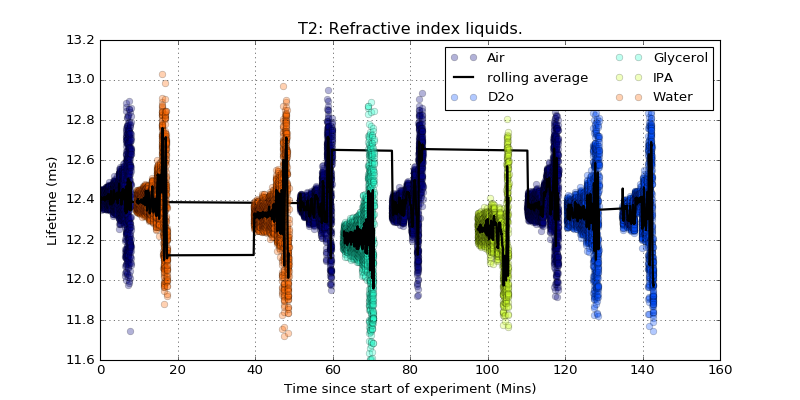

In [34]:
# All in one vs time with moving average
set_colour_map(len(df.medium.unique()))
fig, ax = plt.subplots(figsize=(10,5))
for key, group in df.groupby(['medium']):
    ax.plot(group['delta'], group['tau'], 'o', alpha=0.3, label=key)
    rolling = group['tau'].rolling(window=50).mean()
    ax.plot(group['delta'], rolling, '-', lw=2, label='rolling average', color='black')

ax.grid(True, which='major')
ax.set_xlabel('Time since start of experiment (Mins)')
ax.set_ylabel('Lifetime (ms)')
ax.set_title('{}: Refractive index liquids.'.format(df.chip.unique()[0]))
# Legend only show rolling mean once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', ncol=2, fontsize='medium')

if save:
    plt.savefig(data_folder +  str(folder) + '/lifetimeVsTime_raw.png', dpi=300)

# Drop Data
Drop first water measurement - find corresponding rows to drop

In [27]:
df[(df['medium'] == 'Water') & (df['sweep_no'] == 1) & (df['current'] == 0.5)]

,datetime,chip,current,fs,humidity,measurementID,medium,n,optical power,sample_no,sweep_no,sweeps,t_in,t_out,tempC,A,tau,c,delta
2000,2016-10-11 11:11:36.044876,T2,0.5,0.0001,45.13,T2_refractive_index_liquids3,Water,1.33,0.221851,1200,1,400,21.75,21.5,22.39,0.434297,12.344714,-0.018238,9.400173
4000,2016-10-11 11:41:51.472048,T2,0.5,0.0001,44.42,T2_refractive_index_liquids3,Water,1.33,0.223544,1200,1,400,22.25,22.0,22.78,0.406367,12.284894,-0.017880,39.657293


In [28]:
df[(df['medium'] == 'Water') & (df['sweep_no'] == 400) & (df['current'] == 0.1)]

,datetime,chip,current,fs,humidity,measurementID,medium,n,optical power,sample_no,sweep_no,sweeps,t_in,t_out,tempC,A,tau,c,delta
3999,2016-10-11 11:19:32.610528,T2,0.1,0.0001,44.94,T2_refractive_index_liquids3,Water,1.33,0.028925,1200,400,400,21.75,21.5,22.40,0.048458,12.366795,-0.017873,17.342934
5999,2016-10-11 11:50:55.162728,T2,0.1,0.0001,44.26,T2_refractive_index_liquids3,Water,1.33,0.028603,1200,400,400,22.25,22.0,22.78,0.045851,12.353501,-0.018609,48.718804


In [8]:
df = df.iloc[np.where((df.index < 2000) | (df.index > 3999))[0]]

Drop unwanted medium

In [35]:
# Drop data (error measurements) - IPA was evaporating 
to_drop = ['IPA', 
           'D2o', 
           'Intralipid']
df = df[~df['medium'].isin(to_drop)]

Replot data in time to check correct data was dropped

<IPython.core.display.Javascript object>


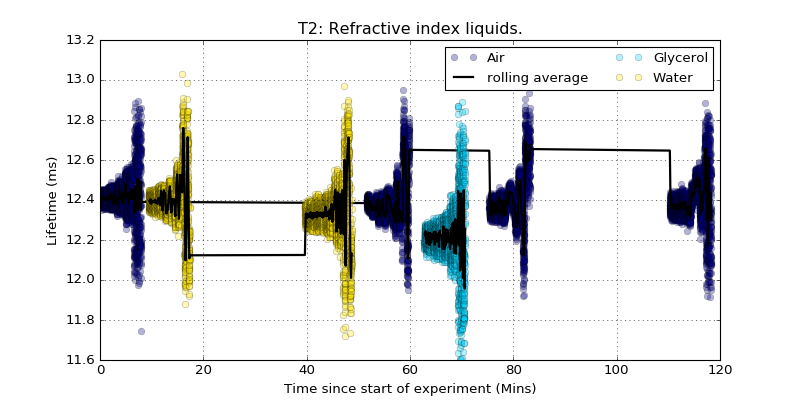

In [36]:
set_colour_map(len(df.medium.unique()))
# All in one vs time with moving average
fig, ax = plt.subplots(figsize=(10,5))
for key, group in df.groupby(['medium']):
    ax.plot(group['delta'], group['tau'], 'o', alpha=0.3, label=key)
    rolling = group['tau'].rolling(window=50).mean()
    ax.plot(group['delta'], rolling, '-', lw=2, label='rolling average', color='black')

ax.grid(True, which='major')
ax.set_xlabel('Time since start of experiment (Mins)')
ax.set_ylabel('Lifetime (ms)')
ax.set_title('{}: Refractive index liquids.'.format(df.chip.unique()[0]))
# Legend only show rolling mean once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', ncol=2, fontsize='medium')

if save:
    plt.savefig(data_folder +  str(folder) + '/lifetimeVsTime_dataCleanup.png', dpi=300)

## Group by current and refractive index and evaluate averate tau & A

In [37]:
### ONLY IF NEED TO ADD REFRACTIVE INDEX VALUES
# Ethanol and methanolspelt wrong...

n = {'Air': 1,
     'Water': 1.3183,
     'Intralipid': 1.35,
     'IPA': 1.3741,
     'D2O': 1.32,
     'Ethanoyl': 1.3509,
     'Methanoyl': 1.3176,
     'Air_end': 1,
     'Glycerol': 1.47,
     'Air2': 1,
     'D2o': 1.32, }
n

{'Air': 1,
 'Air2': 1,
 'Air_end': 1,
 'D2O': 1.32,
 'D2o': 1.32,
 'Ethanoyl': 1.3509,
 'Glycerol': 1.47,
 'IPA': 1.3741,
 'Intralipid': 1.35,
 'Methanoyl': 1.3176,
 'Water': 1.3183}

In [38]:
max(df['sweep_no']) - min(df['sweep_no'])

399

In [39]:
df['n'] = df['medium']
df = df.replace({"n": n})

In [40]:
# Drop unwanted columns (data not interested in, easier to view)
df = df[['n', 'current', 'tau', 'A', 'medium']]
# Apply mean and std functions to all collumns
g = df.groupby(['current', 'n']).agg([np.mean, np.std]).reset_index()
g.head()

current       n        tau                   A          
                        mean       std      mean       std
0     0.1  1.0000  12.458826  0.233409  0.055755  0.003482
1     0.1  1.3183  12.384297  0.283742  0.047169  0.001592
2     0.1  1.4700  12.238032  0.321725  0.043909  0.001020
3     0.2  1.0000  12.404007  0.089143  0.167799  0.008788
4     0.2  1.3183  12.388604  0.101647  0.141054  0.004161

<IPython.core.display.Javascript object>


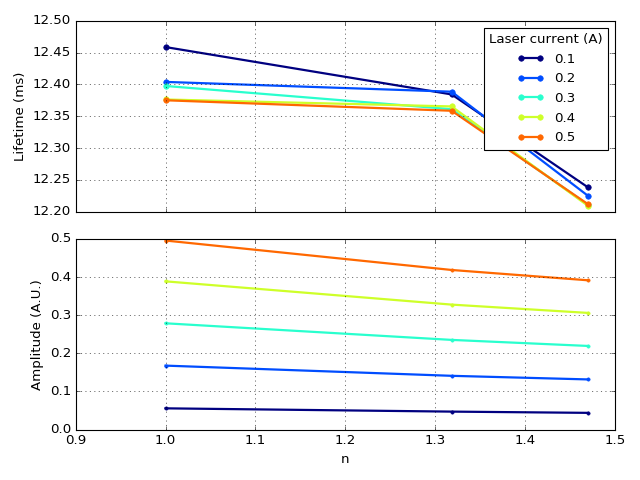

In [41]:
# Two subplots, unpack the axes array immediately
set_colour_map(len(df.current.unique()))
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

for key, group in g.groupby('current'):
    ax1.plot(group['n'], group['tau']['mean'], '.-', lw='2', markersize='10', label=key)
    ax2.plot(group['n'], group['A']['mean'], '.-', lw='2', label=key)

ax2.set_xlabel('n')
ax1.set_ylabel('Lifetime (ms)')
ax2.set_ylabel('Amplitude (A.U.)')

ax1.grid(True)
ax2.grid(True)
plt.tight_layout()
ax1.ticklabel_format(useOffset=False, axis='y')
ax2.ticklabel_format(useOffset=False, axis='y')
ax1.legend(title='Laser current (A)', loc='best', fontsize='medium')
if save:
    plt.savefig(data_folder +  str(folder) + '/final.png', dpi=300)

<IPython.core.display.Javascript object>


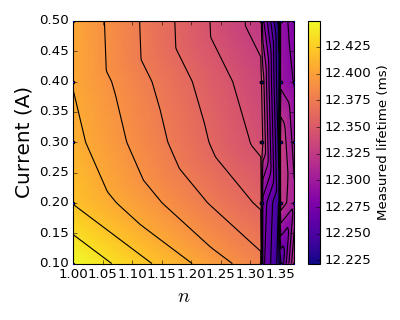

In [63]:
# Contour plot
x = g.n
y = g.current
z = g['tau']['mean']
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
zi = ml.griddata(x, y, z, xi, yi, interp='linear')

fig = plt.figure(figsize=(5,4)) 
ax = fig.add_subplot(111)
plt.contour(xi, yi, zi, 15, linewidths=1, colors='k')
plt.pcolormesh(xi, yi, zi, cmap=plt.get_cmap('plasma'))
cbar = plt.colorbar()
plt.scatter(x, y, marker='o', c='b', s=5, zorder=10)

plt.xlim(min(x), max(x))
plt.ylim(min(y), max(y))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar.ax.set_ylabel('Measured lifetime (ms)', fontsize=12)
ax.set_xlabel('$n$', fontsize=18)
ax.set_ylabel('Current (A)', fontsize=18)
plt.tight_layout()
if save:
    plt.savefig(data_folder +  str(folder) + '/contour_tau.png', dpi=300)

In [42]:
g = g[g['current'] == 0.5]

<IPython.core.display.Javascript object>


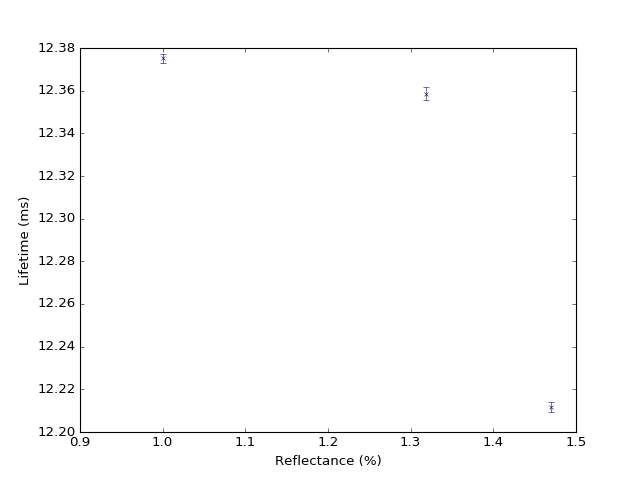

In [49]:
std = g['tau']['std']
sem = std/np.sqrt(249)

# Plotting SEM!!!!
fig, ax1 = plt.subplots()
ax1.errorbar(g['n'], g['tau']['mean'], yerr=sem, fmt='x', ls='', barsabove=True, elinewidth=0.5, markeredgewidth=0.5, ms=3)
# ax1.plot(xp, yp, '-', lw=2)

ax1.set_xlabel('Reflectance (%)')
ax1.set_ylabel('Lifetime (ms)')

# ax1.grid()
ax1.ticklabel_format(useOffset=False, axis='y')

# plt.savefig(data_folder + str(folder) + '/T2_d2o_Water00')

In [47]:
# Save Data
np.savez(data_folder + str(folder) + '/tau_vs_n', n=g['n'], tau=g['tau']['mean'], std=std, sem=sem)